## 项目背景

骨龄是骨骼年龄的简称，需要借助于骨骼在X光摄像中的特定图像来确定。通常要拍摄左手手腕部位的X光片，医生通过X光片观察来确定骨龄。

是一件非常**消耗精力和时间**的一项放射临床工作。写一个骨龄可能要10多分钟去完成。如果一天要写几十个骨龄，估计医生会奔溃~~~

但是发现医生写骨龄的方法。在计算机任务中，好像目标检测 + 分类任务。所有就有这个项目。


## 骨龄和RUS-CHN计分法
#### 这个放射临床骨龄工作，可以看出是一项耗精力耗时间的工作。
#### 需要对照13个关节的图谱才能计算骨龄
#### 等级图谱可以到这个链接查看[图谱链接](http://www.zonghebingqu.top/boneage/)

![](https://ai-studio-static-online.cdn.bcebos.com/178bd9c05138481f8c320e20a94fd157710f2b48f1f740b8a4112877945942db)

![](https://ai-studio-static-online.cdn.bcebos.com/822ad6b6428245cd9aabd9b690f16fa56dcec6e0ff52426e8b90ef542a7b6595)




## 本项目的方法

#### 正是模仿放射医生做骨龄方法。一个个关节找出，分出等级，算总分。

![](https://ai-studio-static-online.cdn.bcebos.com/895e8f3fa56f4dc1bfa2202ca637e41a022b6998c78e4909b0e18fd9c4540fe2)


## 关于数据
![](https://ai-studio-static-online.cdn.bcebos.com/73fc4b41ea774da782e78a55254c1b12839e31e1f2c1449583bee8db9e777449)

![](https://ai-studio-static-online.cdn.bcebos.com/dad1aa98974c4bceb6104ba0fbf43ab11a6785dfbfd449f8a5296177e6b2c167)


## 项目开始
训练9个模型

In [ ]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# 初次运行时需要将下面两行注释取消
# !mkdir /home/aistudio/external-libraries
# !pip install imgaug -t /home/aistudio/external-libraries 

# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可:
import sys
sys.path.append('/home/aistudio/external-libraries')

In [ ]:
#导入一些常见的库 
%cd /home/aistudio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil, cv2, random
import paddle

/home/aistudio


In [ ]:
#解压数据
#初次运行去掉注释
# !unzip -q /home/aistudio/data/data69582/arthrosis.zip -d /home/aistudio/work/

In [ ]:
# 生成train.txt 和 val.txt
def save_file(list, path, name):
    myfile=os.path.join(path,name)
    if os.path.exists(myfile):
        os.remove(myfile)
    with open(myfile, "w") as f:
        f.writelines(list)
        
pic_path_folder = "/home/aistudio/work/arthrosis"
for  pic_folder in os.listdir(pic_path_folder):
    data_path = "/home/aistudio/work/arthrosis/" + pic_folder
    num_class = len(os.listdir(data_path))
    train_list = []
    val_list = []
    train_ratio = 0.9
    for folder in os.listdir(data_path):
        if os.path.isfile(os.path.join(data_path, folder)):
            continue
        train_nums = len(os.listdir(os.path.join(data_path, folder))) * train_ratio
        img_lists =os.listdir(os.path.join(data_path, folder)) 
        random.shuffle(img_lists)
        for index, img in enumerate(img_lists):
            if index < train_nums:
                train_list.append(os.path.join(data_path, folder, img) + ' ' + str(int(folder)-1) + '\n')
            else :
                val_list.append(os.path.join(data_path, folder, img) + ' ' + str(int(folder)-1) + '\n')

    random.shuffle(train_list)
    random.shuffle(val_list)
    save_file(train_list,  data_path,'train.txt')
    save_file(val_list,  data_path,'val.txt')
print("完成")

完成


In [ ]:
#创建Dataset
#里面用了很多数据增强，因为数据集实在太小

import os
from paddle.vision.transforms import Compose, ColorJitter, Resize
from paddle.vision.transforms import RandomHorizontalFlip,RandomRotation,Normalize,RandomCrop,Transpose
import paddle
import numpy as np
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa

import random
train_transforms = Compose([Resize(size=(224,224)),
                            # RandomCrop((224,224)),
                            ColorJitter(0.3, 0.3, 0.3, 0.2),
                            RandomHorizontalFlip(),
                            # RandomRotation(15),
                            Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5],data_format='HWC'),
                            Transpose()])

val_transforms = Compose([Resize(size=(224,224)),
                        Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5],data_format='HWC'),
                        Transpose()])

def mytransform(img):
    img = np.array([img])
    ia.seed(random.randint(0, 10000))
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [

            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1), "y": (0.9, 1)},

                rotate=(-15, 15),
                shear=(-10, 10),
                mode=ia.ALL
            )),
            sometimes(iaa.OneOf([
                iaa.GaussianBlur((0, 1.0)),
                # iaa.AverageBlur(k=(2, 5)),
                # iaa.MedianBlur(k=(3,7)),
            ])),
            sometimes(iaa.OneOf([
                iaa.EdgeDetect(alpha=(0, 0.5)),
            ])),
            sometimes(iaa.Sharpen(alpha=(0, 1), lightness=(0.75, 1.5))),
            sometimes(iaa.Emboss(alpha=(0, 1), strength=(0, 2.0)),),
        ],
        random_order=True
    )
    img = seq(images=img)
    img = img[0]
    return img
    
class Dataset(paddle.io.Dataset):
    def __init__(self,
                 transforms,
                 mode='train',
                 train_path=None,
                 val_path=None,
                 separator=' ',):
        self.transforms = transforms
        self.file_list = list()
        mode = mode.lower()
        self.mode = mode
        if self.mode  == 'train':
            file_path = train_path
        elif self.mode  == 'val':
            file_path = val_path

        with open(file_path, 'r') as f:
            for line in f:
                items = line.strip().split(separator)
                image_path = items[0]
                label = int(items[1])
                self.file_list.append([image_path, label])

    def __getitem__(self, idx):
        image_path, label = self.file_list[idx]
        im = Image.open(image_path)
        im = np.array(im)
        if self.mode  == 'train':
            im = mytransform(im)
        im = self.transforms(im).astype("float32")
        label = np.array([label], dtype="int64")
        return im, label

    def __len__(self):
        return len(self.file_list)

In [ ]:
#9个大类，每个大类里面有多少个等级分类
#方便循环训练9个分类模型

arthrosis ={'MCPFirst':['MCPFirst',11],  #第一手指掌骨
            'DIPFirst':['DIPFirst',11],  #第一手指远节指骨
            'PIPFirst':['PIPFirst',12],  #第一手指近节指骨
            'MIP':['MIP',12],            #中节指骨（除了拇指剩下四只手指）（第一手指【拇指】是没有中节指骨的））
            'Radius':['Radius',14],      #桡骨
            'Ulna':['Ulna',12],          #尺骨
            'PIP':['PIP',12],            #近节指骨（除了拇指剩下四只手指）
            'DIP':['DIP',11],            #远节指骨（除了拇指剩下四只手指）
            'MCP':['MCP',10]}            #掌骨（除了拇指剩下四只手指）

category = arthrosis['Radius']

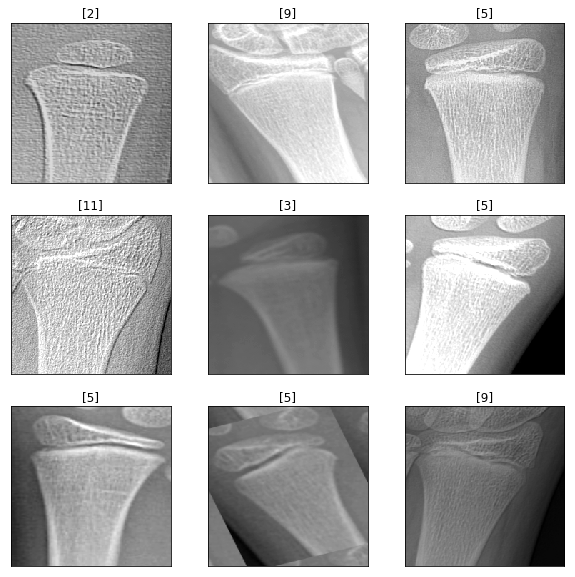

In [ ]:
#预览部分数据
import matplotlib.pyplot  as plt
train_txt = '/home/aistudio/work/arthrosis/' + category[0] + '/train.txt'
train_dataset = Dataset(train_transforms,'train',train_path=train_txt)
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]
plt.figure(figsize=(10,10))
for index , data in enumerate(train_dataset):
    plt.subplot(3,3,index+1)
    x_data = data[0]
    y_data = data[1]

    x_data = x_data.transpose(1,2,0)
    x_data = x_data * std  + mean
    x_data = x_data.astype(np.uint32)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(y_data))
    plt.imshow(x_data)
    if index == 8:
        break
plt.show()


In [ ]:
#开始训练
%cd /home/aistudio/
import paddle
import paddle.fluid as fluid
import numpy as np
from visualdl import LogWriter

def samplePairing(img1, img2):
    img1 = img1.numpy()
    img2 = img2.numpy()
    img1 = np.transpose(img1,(1,2,0))
    img2 = np.transpose(img2, (1,2,0))
    h = max(img1.shape[0], img2.shape[0])
    w = max(img1.shape[1], img2.shape[1])
    img = np.zeros((h, w, img1.shape[2]), 'float32')
    img[:img1.shape[0], :img1.shape[1], :] = img1.astype('float32') / 2
    img[:img2.shape[0], :img2.shape[1], :] += img2.astype('float32') / 2
    if img1.dtype == 'uint8':
        return img.astype('uint8')   # 处理、返回归一化前图片 
    else:
        return np.transpose(img,(2,0,1))    
num_classes = category[1]
epoch_num = 40
batch_size = 16

learning_rate = 0.00002


def train(model,category):
    train_txt = '/home/aistudio/work/arthrosis/' + category + '/train.txt'
    val_txt = '/home/aistudio/work/arthrosis/' + category + '/val.txt'
    train_dataset = Dataset(train_transforms,'train',train_path=train_txt)
    val_dataset = Dataset(val_transforms, 'val', val_path=val_txt)
    t_max = len(train_dataset) //  batch_size * epoch_num
    print('{}_开始训练 ... '.format(category))
    sample_pairing_start_epoch = int(0)
    sample_pairing_end_epoch = epoch_num - sample_pairing_start_epoch

    best_acc = 0.0
    model.train()
   
    # scheduler = paddle.optimizer.lr.LambdaDecay(learning_rate=learning_rate, lr_lambda=lambda x:0.9**x, verbose=True)
    # scheduler = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=learning_rate, factor=0.5, patience=5, verbose=True)
    scheduler = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=learning_rate, T_max=t_max, verbose=True)
    # scheduler = paddle.optimizer.lr.PolynomialDecay(learning_rate=learning_rate, decay_steps=20, end_lr=0.00000125,cycle=True,verbose =True)
    opt = paddle.optimizer.Adam(learning_rate=scheduler,parameters=model.parameters())
    # opt = paddle.optimizer.Momentum(learning_rate=scheduler, parameters=model.parameters(), weight_decay=0.01)

    train_loader = paddle.io.DataLoader(train_dataset,shuffle=True,batch_size=batch_size)
    valid_loader = paddle.io.DataLoader(val_dataset, batch_size=batch_size)
    with LogWriter(logdir="/home/aistudio/log/scalar_test/train") as writer:

        for epoch in range(epoch_num):
            acces = []
            losses = []
            for batch_id, data in enumerate(train_loader()):
                x_data = data[0]
                #是否采用sample_pairing（类似mixup  的数据增强）
                # if epoch >= sample_pairing_start_epoch and epoch < sample_pairing_end_epoch and epoch % 10 < 5:
                #     for i in range(x_data.shape[0]):
                #         x_data[i] = samplePairing(x_data[i], x_data[np.random.randint(0, x_data.shape[0])])

                x_data = paddle.to_tensor(x_data, dtype='float32')
                y_data =  paddle.to_tensor(data[1], dtype='int64')

                output = model(x_data)
                acc = paddle.metric.accuracy(output, y_data, k=1)
                ce_loss = paddle.nn.loss.CrossEntropyLoss(ignore_index=0,reduction='mean')
                loss = ce_loss(output, y_data) # 计算交叉熵
                acces.append(np.mean(acc.numpy()))
                losses.append(np.mean(loss.numpy()))
                if batch_id % 20 == 0:
                    print("epoch: {}, batch_id: {}, acc:{},loss is: {}".format(epoch, batch_id, acc.numpy(),loss.numpy()))
                loss.backward()
                opt.minimize(loss)
                model.clear_gradients()
            scheduler.step()
            
            avg_acc, avg_loss = np.mean(acces), np.mean(losses)
            writer.add_scalar(tag="{}_train_acc".format(category), step=epoch, value=avg_acc)
            writer.add_scalar(tag="{}_train_loss".format(category), step=epoch, value=avg_loss)

            #训练期间验证
            model.eval()
            acces = []
            losses = []
            for batch_id, data in enumerate(valid_loader()):
                x_data = paddle.to_tensor(data[0], dtype='float32')
                y_data =  paddle.to_tensor(data[1], dtype='int64')
        
                output = model(x_data)
                acc = paddle.metric.accuracy(output, y_data, k=1)
                ce_loss = paddle.nn.loss.CrossEntropyLoss(ignore_index=0,reduction='mean')
                loss = ce_loss(output, y_data) # 计算交叉熵
                
                acces.append(np.mean(acc.numpy()))
                losses.append(np.mean(loss.numpy()))
            avg_acc, avg_loss = np.mean(acces), np.mean(losses)
            print("[validation_{}] acc/loss: {}/{}".format(category,avg_acc, avg_loss))
            writer.add_scalar(tag="{}_val_acc".format(category), step=epoch, value=avg_acc)
            writer.add_scalar(tag="{}_val_loss".format(category), step=epoch, value=avg_loss)
            model.train()
            if avg_acc > best_acc :
                best_acc = avg_acc
                paddle.save(model.state_dict(), '/home/aistudio/work/out/'+ 'best_'+ category +'_net.pdparams')
                print('成功保存模型')

for key,value in arthrosis.items():

    model = paddle.vision.models.resnet50(pretrained=True, num_classes=value[1])
    train(model,value[0])

In [ ]:
#训练9个模型， 在验证集的精度平均只有70多。。。。。

import paddle
import numpy as np
val_txt = '/home/aistudio/work/arthrosis/' + category[0] + '/val.txt'
val_dataset = Dataset(val_transforms, 'val', val_path=val_txt)
model = paddle.vision.models.resnet50(num_classes=category[1])
model_path = '/home/aistudio/work/out/'+ 'best_'+ category[0] +'_net.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
model.eval()
l = val_dataset.__len__()
num = 0
for i, data in enumerate(val_dataset) :
    x = data [0]
    y = data[1]
    x = np.expand_dims(x, 0)
    x = paddle.to_tensor(x, dtype='float32')
    result = model(x)[0]
    result = np.argmax(result.numpy()) #获得最大值所在的序号
    if int(y[0]) == int(result):
        num += 1
print("{}  ACC:{}".format(category[0],num/l))

Radius  ACC:0.7457627118644068


In [ ]:
from PIL import Image
from paddle.vision.transforms import Compose,Resize, Normalize, Transpose
transforms = Compose([Resize(size=(224,224)),
                        Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5],data_format='HWC'),
                        Transpose()])
model = paddle.vision.models.resnet50( num_classes=12)
model_path = '/home/aistudio/work/out/best_MIP_net.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)

model.eval()
img_path = '/home/aistudio/work/arthrosis/MIP/7/MID_555112.png'
im = Image.open(img_path)
infer_data = transforms(im)
infer_data = np.expand_dims(infer_data,0)
infer_data = paddle.to_tensor(infer_data, dtype='float32')
result = model(infer_data)[0] 
result = np.argmax(result.numpy()) 
print(result+1)


7


## 训练检测模型(paddledetection)

In [16]:
#解压数据
#初次运行要解压
# ! unzip -q -o /home/aistudio/data/data36951/voc.zip -d /home/aistudio/work/PaddleDetection/dataset

In [ ]:

%cd /home/aistudio/work/PaddleDetection

/home/aistudio/work/PaddleDetection


In [ ]:
#训练
!python -u tools/train.py -c /home/aistudio/work/PaddleDetection/configs/yolov3_darknet_voc.yml \
                        --use_vdl=true \
                        --vdl_log_dir=vdl_dir/scalar \
                        --eval

In [ ]:
#一键预测
! python tools/infer.py \
    -c tools/train.py \
    -c /home/aistudio/work/PaddleDetection/configs/yolov3_darknet_voc.yml  \
    -o weights=output/yolov3_darknet_voc/best_model \
    --infer_img=/home/aistudio/1.jpg \
     --draw_threshold=0.2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


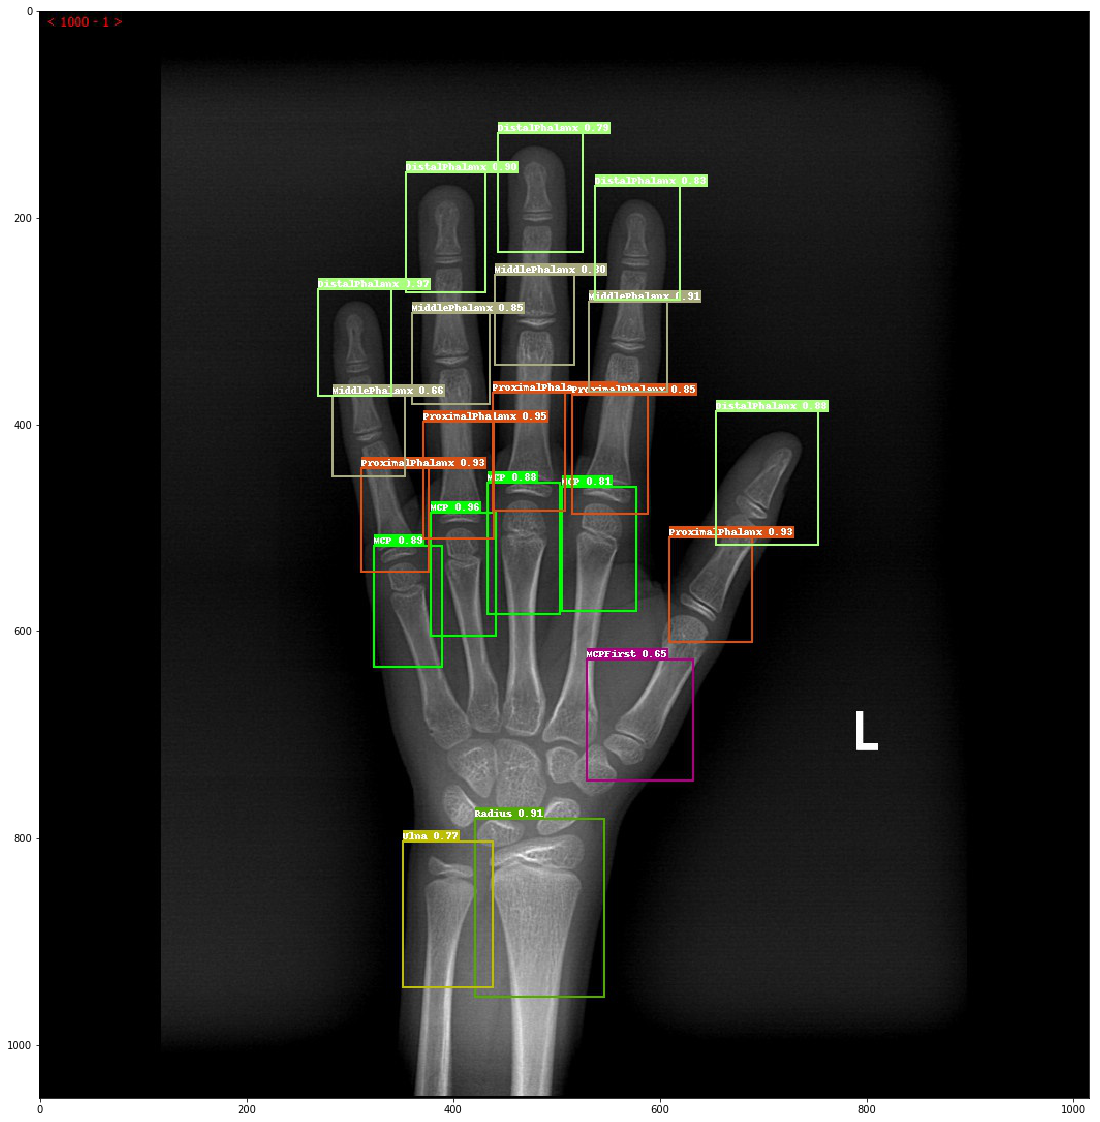

In [ ]:

#展示预测图片
%matplotlib inline
import matplotlib.pyplot as plt 
from PIL import Image

infer_img = Image.open("/home/aistudio/work/PaddleDetection/output/1.jpg")
plt.figure(figsize=(20, 20))
plt.imshow(infer_img)
plt.show()

In [ ]:
#导出模型
#已经训练了mAP 有 91的模型,已经导出到这个路径work/PaddleDetection/inference_model
# !python tools/export_model.py \
#     -c configs/yolov3_darknet_voc.yml \
#     --output_dir=./inference_model \
#     -o weights=output/yolov3_darknet_voc/best_model 

## 检测+分类开始计算骨龄

In [ ]:
#导入重要的库 ，和定义函数

import os, sys
sys.path.append('/home/aistudio/work/PaddleDetection/deploy/python/')
import yaml
import ast
from functools import reduce
from PIL import Image

import matplotlib.pyplot as plt
import cv2
import numpy as np
import paddle
import paddle.fluid as fluid
from preprocess import preprocess, Resize, Normalize, Permute, PadStride

#这个是等级对应的标准分
import math
SCORE = {'girl':{
    'Radius':[10,15,22,25,40,59,91,125,138,178,192,199,203, 210],
    'Ulna':[27,31,36,50,73,95,120,157,168,176,182,189],
    'MCPFirst':[5,7,10,16,23,28,34,41,47,53,66],
    'MCPThird':[3,5,6,9,14,21,32,40,47,51],
    'MCPFifth':[4,5,7,10,15,22,33,43,47,51],
    'PIPFirst':[6,7,8,11,17,26,32,38,45,53,60,67],
    'PIPThird':[3,5,7,9,15,20,25,29,35,41,46,51],
    'PIPFifth':[4,5,7,11,18,21,25,29,34,40,45,50],
    'MIPThird':[4,5,7,10,16,21,25,29,35,43,46,51],
    'MIPFifth':[3,5,7,12,19,23,27,32,35,39,43,49],
    'DIPFirst':[5,6,8,10,20,31,38,44,45,52,67],
    'DIPThird':[3,5,7,10,16,24,30,33,36,39,49],
    'DIPFifth':[5,6,7,11,18,25,29,33,35,39,49]
},
    'boy':{
    'Radius':[8,11,15,18,31,46,76,118,135,171,188,197,201,209],
    'Ulna':[25,30,35,43,61,80,116,157,168,180,187,194],
    'MCPFirst':[4,5,8,16,22,26,34,39,45,52,66],
    'MCPThird':[3,4,5,8,13,19,30,38,44,51],
    'MCPFifth':[3,4,6,9,14,19,31,41,46,50],
    'PIPFirst':[4,5,7,11,17,23,29,36,44,52,59,66],
    'PIPThird':[3,4,5,8,14,19,23,28,34,40,45,50],
    'PIPFifth':[3,4,6,10,16,19,24,28,33,40,44,50],
    'MIPThird':[3,4,5,9,14,18,23,28,35,42,45,50],
    'MIPFifth':[3,4,6,11,17,21,26,31,36,40,43,49],
    'DIPFirst':[4,5,6,9,19,28,36,43,46,51,67],
    'DIPThird':[3,4,5,9,15,23,29,33,37,40,49],
    'DIPFifth':[3,4,6,11,17,23,29,32,36,40,49]
    }
}

def calcBoneAge(score, sex):
    #根据总分计算对应的年龄
    if sex == 'boy':
        boneAge = 2.01790023656577 + (-0.0931820870747269)*score + math.pow(score,2)*0.00334709095418796 +\
        math.pow(score,3)*(-3.32988302362153E-05) + math.pow(score,4)*(1.75712910819776E-07) +\
        math.pow(score,5)*(-5.59998691223273E-10) + math.pow(score,6)*(1.1296711294933E-12) +\
        math.pow(score,7)* (-1.45218037113138e-15) +math.pow(score,8)* (1.15333377080353e-18) +\
        math.pow(score,9)*(-5.15887481551927e-22) +math.pow(score,10)* (9.94098428102335e-26)
        return round(boneAge,2)
    elif sex == 'girl':
        boneAge = 5.81191794824917 + (-0.271546561737745)*score + \
        math.pow(score,2)*0.00526301486340724 + math.pow(score,3)*(-4.37797717401925E-05) +\
        math.pow(score,4)*(2.0858722025667E-07) +math.pow(score,5)*(-6.21879866563429E-10) + \
        math.pow(score,6)*(1.19909931745368E-12) +math.pow(score,7)* (-1.49462900826936E-15) +\
        math.pow(score,8)* (1.162435538672E-18) +math.pow(score,9)*(-5.12713017846218E-22) +\
        math.pow(score,10)* (9.78989966891478E-26)
        return round(boneAge,2)


#13个关节对应的分类模型
arthrosis ={'MCPFirst':['MCPFirst',11],
            'MCPThird':['MCP',10],
            'MCPFifth':['MCP',10],

            'DIPFirst':['DIPFirst',11],
            'DIPThird':['DIP',11],
            'DIPFifth':['DIP',11],

            'PIPFirst':['PIPFirst',12],
            'PIPThird':['PIP',12],
            'PIPFifth':['PIP',12],

            'MIPThird':['MIP',12],
            'MIPFifth':['MIP',12],

            'Radius':['Radius',14],
            'Ulna':['Ulna',12],}

#简化了work/PaddleDetection/deploy/python/infer.py  这个文件
class Detector(object):

    def __init__(self,
                 config,
                 model_dir,
                 use_gpu=False,
                 run_mode='fluid',
                 threshold=0.5):
        self.config = config
        self.predictor = load_predictor(
            model_dir,
            run_mode=run_mode,
            min_subgraph_size=self.config.min_subgraph_size,
            use_gpu=use_gpu)

    def preprocess(self, im):
        preprocess_ops = []
        for op_info in self.config.preprocess_infos:
            new_op_info = op_info.copy()
            op_type = new_op_info.pop('type')
            if op_type == 'Resize':
                new_op_info['arch'] = self.config.arch
            preprocess_ops.append(eval(op_type)(**new_op_info))
        im, im_info = preprocess(im, preprocess_ops)
        inputs = create_inputs(im, im_info, self.config.arch)
        return inputs, im_info

    def postprocess(self, np_boxes, np_masks, np_lmk, im_info, threshold=0.5):
        results = {}
        expect_boxes = (np_boxes[:, 1] > threshold) & (np_boxes[:, 0] > -1)
        np_boxes = np_boxes[expect_boxes, :]
        results['boxes'] = np_boxes
        return results

    def predict(self,
                image,
                threshold=0.2,
                warmup=0,
                repeats=1,
                run_benchmark=False):

        inputs, im_info = self.preprocess(image)
        np_boxes, np_masks, np_lmk = None, None, None

        input_names = self.predictor.get_input_names()
        for i in range(len(input_names)):
            input_tensor = self.predictor.get_input_tensor(input_names[i])
            input_tensor.copy_from_cpu(inputs[input_names[i]])

        for i in range(repeats):
            self.predictor.zero_copy_run()
            output_names = self.predictor.get_output_names()
            boxes_tensor = self.predictor.get_output_tensor(output_names[0])
            np_boxes = boxes_tensor.copy_to_cpu()

        results = []
        if not run_benchmark:
            results = self.postprocess(
                np_boxes, np_masks, np_lmk, im_info, threshold=threshold)
        return results


def create_inputs(im, im_info, model_arch='YOLO'):
    inputs = {}
    inputs['image'] = im
    origin_shape = list(im_info['origin_shape'])
    resize_shape = list(im_info['resize_shape'])
    pad_shape = list(im_info['pad_shape']) if im_info[
        'pad_shape'] is not None else list(im_info['resize_shape'])
    scale_x, scale_y = im_info['scale']
    im_size = np.array([origin_shape]).astype('int32')
    inputs['im_size'] = im_size
    return inputs

def load_predictor(model_dir,
                   run_mode='fluid',
                   batch_size=1,
                   use_gpu=False,
                   min_subgraph_size=3):

    if not use_gpu and not run_mode == 'fluid':
        raise ValueError(
            "Predict by TensorRT mode: {}, expect use_gpu==True, but use_gpu == {}"
            .format(run_mode, use_gpu))
    if run_mode == 'trt_int8':
        raise ValueError("TensorRT int8 mode is not supported now, "
                         "please use trt_fp32 or trt_fp16 instead.")
    precision_map = {
        'trt_int8': fluid.core.AnalysisConfig.Precision.Int8,
        'trt_fp32': fluid.core.AnalysisConfig.Precision.Float32,
        'trt_fp16': fluid.core.AnalysisConfig.Precision.Half
    }
    config = fluid.core.AnalysisConfig(
        os.path.join(model_dir, '__model__'),
        os.path.join(model_dir, '__params__'))
    if use_gpu:
        config.enable_use_gpu(100, 0)
        config.switch_ir_optim(True)
    else:
        config.disable_gpu()

    if run_mode in precision_map.keys():
        config.enable_tensorrt_engine(
            workspace_size=1 << 10,
            max_batch_size=batch_size,
            min_subgraph_size=min_subgraph_size,
            precision_mode=precision_map[run_mode],
            use_static=False,
            use_calib_mode=False)

    config.disable_glog_info()
    config.enable_memory_optim()
    config.switch_use_feed_fetch_ops(False)
    predictor = fluid.core.create_paddle_predictor(config)
    return predictor

def predict_image(detector, image_file, threshold):
    results = detector.predict(image_file, threshold)
    return results

class Config():
    def __init__(self, model_dir):
        deploy_file = os.path.join(model_dir, 'infer_cfg.yml')
        with open(deploy_file) as f:
            yml_conf = yaml.safe_load(f)
        self.arch = yml_conf['arch']
        self.preprocess_infos = yml_conf['Preprocess']
        self.use_python_inference = yml_conf['use_python_inference']
        self.min_subgraph_size = yml_conf['min_subgraph_size']
        self.labels = yml_conf['label_list']


def predictClass(im,classifer,num_classes):
    #预测小关节的等级
    from paddle.vision.transforms import Compose,Resize, Normalize, Transpose
    transforms = Compose([Resize(size=(224,224)),
                            Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5],data_format='HWC'),
                            Transpose()])
    model = paddle.vision.models.resnet50( num_classes=num_classes)
    model_path = '/home/aistudio/work/out2/best_'+classifer +'_net.pdparams'
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    model.eval()
    im = np.expand_dims(im, 2)
    infer_data = transforms(im)
    infer_data = np.expand_dims(infer_data,0)
    infer_data = paddle.to_tensor(infer_data, dtype='float32')
    result = model(infer_data)[0] #关键代码，实现预测功能
    result = np.argmax(result.numpy()) #获得最大值所在的序号
    return result 


In [14]:

#开始计算骨龄
#注意性别，不同性别记分不同
sex = 'girl'
label ={}
classifer = {}
model_dir = '/home/aistudio/work/PaddleDetection/inference_model/yolov3_darknet_voc'
image_file = '/home/aistudio/1.jpg'

configDict = {}
configDict['model_dir'] = model_dir
configDict['image_file'] = image_file
configDict['threshold'] = 0.2
configDict['use_gpu'] = False
configDict['run_mode'] = 'fluid'
config = Config(configDict['model_dir'])
detector = Detector(
    config, configDict['model_dir'], use_gpu=configDict['use_gpu'], run_mode=configDict['run_mode'])
results = predict_image(detector,configDict['image_file'],configDict['threshold'])
if len(results['boxes']) != 21:
    print("推理失败")
for box in results['boxes']:
    if int(box[0])  not in classifer:
        classifer[int(box[0])] = []
        classifer[int(box[0])].append([int(box[2]), int(box[3]), int(box[4]), int(box[5])])
    else:
        classifer[int(box[0])].append([int(box[2]), int(box[3]), int(box[4]), int(box[5])])
if len(classifer[0]) !=1 or len(classifer[1])!=1 or len(classifer[2])!=1:
    raise ValueError('推理失败')
if len(classifer[3]) !=4 or len(classifer[4])!=5 or len(classifer[5])!=4 or len(classifer[6])!=5:
    raise ValueError('推理失败')

#True 是左手， False是右手，一般是左手
Hand = True
#判断左右手，第一手指掌骨的left 比尺骨的left要大就是左手
if classifer[2][0][0] > classifer[1][0][0]:
    Hand = True
else:
    Hand = False

label['Radius'] = classifer[0][0]
label['Ulna'] = classifer[1][0]
label['MCPFirst'] = classifer[2][0]

#4个MCP中，根据left的大到小排列，分出第三手指掌骨，和第五手指掌骨，因为只需要第三和第五掌骨，其他同理
MCP = sorted(classifer[3], key=(lambda x : [x[0]]), reverse=Hand)
label['MCPThird'] = MCP[1]
label['MCPFifth'] = MCP[3]

#5个ProximalPhalanx中，根据left的大到小排列，分出第一近节指骨，第三近节指骨，第五近节指骨
PIP = sorted(classifer[4], key=(lambda x : [x[0]]), reverse=Hand)
label['PIPFirst'] = PIP[0]
label['PIPThird'] = PIP[2]
label['PIPFifth'] = PIP[4]

#4个MiddlePhalanx中，根据left的大到小排列，分出第三中节指骨，第三中节指骨
MIP = sorted(classifer[5], key=(lambda x : [x[0]]), reverse=Hand)
label['MIPThird'] = MIP[1]
label['MIPFifth'] = MIP[3]

#5个DistalPhalanx中，根据left的大到小排列，分出第一远节指骨，第三远节指骨，第五远节指骨
DIP = sorted(classifer[6], key=(lambda x : [x[0]]), reverse=Hand)
label['DIPFirst'] = DIP[0]
label['DIPThird'] = DIP[2]
label['DIPFifth'] = DIP[4]

image = cv2.imread(image_file,0)
results = {}

# 设置字体 每个关节旁边都写上预测的等级
font = cv2.FONT_HERSHEY_DUPLEX  

for key, value in label.items():
    #每个关节通过模型推理，得到对应的等级
    category = arthrosis[key]
    left,top, right, bottom = value
    #从原图根据检测出来的boxes 抠出来，传入分类模型中进行预测
    image_temp = image[top:bottom,left:right]
    #预测等级
    result = predictClass(image_temp,category[0], category[1] )
    #图上画框框和预测的等级
    # cv2.rectangle(image,(left, top), (right,bottom), (225,255,255), 2)
    # cv2.putText(image, "L:{}".format(result+1), (right+3, top +40), font, 0.9, (225,255,255), 2,)
    results[key] = result

score = 0
for key,value in results.items():
    #根据每个关节的等级，计算总得分
    score += SCORE[sex][key][value]

#计算对应的骨龄 
boneAge = calcBoneAge(score, sex)

#规范报告
report = """
第一掌骨骺分级{}级，得{}分；第三掌骨骨骺分级{}级，得{}分；第五掌骨骨骺分级{}级，得{}分；
第一近节指骨骨骺分级{}级，得{}分；第三近节指骨骨骺分级{}级，得{}分；第五近节指骨骨骺分级{}级，得{}分；
第三中节指骨骨骺分级{}级，得{}分；第五中节指骨骨骺分级{}级，得{}分；
第一远节指骨骨骺分级{}级，得{}分；第三远节指骨骨骺分级{}级，得{}分；第五远节指骨骨骺分级{}级，得{}分；
尺骨分级{}级，得{}分；桡骨骨骺分级{}级，得{}分。

RUS-CHN分级计分法，受检儿CHN总得分：{}分，骨龄约为{}岁。""".format(
                                                            results['MCPFirst']+1,SCORE[sex]['MCPFirst'][results['MCPFirst']],\
                                                            results['MCPThird']+1,SCORE[sex]['MCPThird'][results['MCPThird']],\
                                                            results['MCPFifth']+1,SCORE[sex]['MCPFifth'][results['MCPFifth']],\
                                                            results['PIPFirst']+1,SCORE[sex]['PIPFirst'][results['PIPFirst']],\
                                                            results['PIPThird']+1,SCORE[sex]['PIPThird'][results['PIPThird']],\
                                                            results['PIPFifth']+1,SCORE[sex]['PIPFifth'][results['PIPFifth']],\
                                                            results['MIPThird']+1,SCORE[sex]['MIPThird'][results['MIPThird']],\
                                                            results['MIPFifth']+1,SCORE[sex]['MIPFifth'][results['MIPFifth']],\
                                                            results['DIPFirst']+1,SCORE[sex]['DIPFirst'][results['DIPFirst']],\
                                                            results['DIPThird']+1,SCORE[sex]['DIPThird'][results['DIPThird']],\
                                                            results['DIPFifth']+1,SCORE[sex]['DIPFifth'][results['DIPFifth']],\
                                                            results['Ulna']+1,SCORE[sex]['Ulna'][results['Ulna']],\
                                                            results['Radius']+1,SCORE[sex]['Radius'][results['Radius']],\
                                                            score,boneAge)
print(report)
# plt.figure(figsize=(10,10))
# plt.imshow(image,'gray')
# plt.xticks([]),plt.yticks([])
# plt.show()


第一掌骨骺分级3级，得8分；第三掌骨骨骺分级4级，得8分；第五掌骨骨骺分级3级，得6分；
第一近节指骨骨骺分级4级，得11分；第三近节指骨骨骺分级4级，得8分；第五近节指骨骨骺分级3级，得6分；
第三中节指骨骨骺分级4级，得9分；第五中节指骨骨骺分级4级，得11分；
第一远节指骨骨骺分级4级，得9分；第三远节指骨骨骺分级3级，得5分；第五远节指骨骨骺分级3级，得6分；
尺骨分级3级，得35分；桡骨骨骺分级4级，得18分。

RUS-CHN分级计分法，受检儿CHN总得分：140分，骨龄约为7.72岁。


#预测比较 

图一是预测结果，图二是医生诊断结果


骨龄1
![](https://ai-studio-static-online.cdn.bcebos.com/60450dff6fb149399bdb4ae1d3cc90490e1211f37aa14d52aa95c350a505765e)
![](https://ai-studio-static-online.cdn.bcebos.com/f05dadec06384ae4b003b2fccf75bdf610e812bf1f9f4c6c8c28c5dccbd6e831)


骨龄2
![](https://ai-studio-static-online.cdn.bcebos.com/680003812bfe4b61a49399117a0c9bf9f8268ec4eafc4ee4885f59df71f723df)
![](https://ai-studio-static-online.cdn.bcebos.com/5e4c34648a7d4b71a5ffe0a5e9550a0df8bf54c72c15450aa0ebdbb7e2663796)



骨龄3
![](https://ai-studio-static-online.cdn.bcebos.com/4f89c9fb02db4159b944219120e78f1445ba72c120c54badb1a109b6234be1e0)
![](https://ai-studio-static-online.cdn.bcebos.com/c26be6505a7f4fb1b0417a7d24ceb2bfcd6ef47d2dbe4c95b9ed6daeca299dee)


骨龄4
![](https://ai-studio-static-online.cdn.bcebos.com/1094f590115f4a8295fea9fddef3611be382fa33f0024930a6cf9ba69b6291c3)
![](https://ai-studio-static-online.cdn.bcebos.com/50dcdd6e5c584a9c915e27b6371eecc27f88efc4f7584203b40cbc0e3eb9c707)


骨龄5
![](https://ai-studio-static-online.cdn.bcebos.com/9555a91fa8e345baa0952519ba26a6563724e822ec764fcdae442503ee8bf2ee)
![](https://ai-studio-static-online.cdn.bcebos.com/082f9c76cffa43ec9b3f9d7aab378fe972ca63f1f87542e786a152dd8efcb18e)


## 总结

虽然训练分类模型的精度不是很高，但是整体效果还是可以。本来临床需要诊断骨龄需要10多分钟，现在缩短到1分钟左右就可以。后续会不断调整数据，增加数据，训练一个更好的模型。后面会压缩模型，结合pyqt部署成桌面应用，会投放到科室给临床使用。这个检测+分类的工作方式，其实还有一个好处，就是临床可以看到每个关节的预测效果，根据临床的需要，可以自行判断关节是否预测准确，给予适当的修正。而不是黑盒子出来一个骨龄数字，直接下诊断。最终还是回归到机器辅助医生下诊断。

## 个人介绍
广州某医院的放射科的一名放射技师。

只是一位编程爱好者

只是想把自己的爱好融入工作中

只是想让自己通过努力获取成就和快乐

欢迎更多志同道合的朋友一起玩耍~~~

我在AI Studio上获得钻石等级，点亮10个徽章，来互关呀~ [https://aistudio.baidu.com/aistudio/personalcenter/thirdview/181096](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/181096)